In [ ]:
# Install required dependencies
!pip install kaggle

# Set up the Kaggle API token (for private datasets)
import os

# Upload your kaggle.json file in the correct directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp /kaggle/input/kagglejson/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d felicepollano/watermarked-not-watermarked-images -p /kaggle/working/
!unzip /kaggle/working/watermarked-not-watermarked-images.zip -d /kaggle/working/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


cp: cannot stat '/kaggle/input/kagglejson/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/felicepollano/watermarked-not-watermarked-images
License(s): CC-BY-NC-SA-4.0
watermarked-not-watermarked-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /kaggle/working/watermarked-not-watermarked-images.zip
replace /kaggle/working/wm-nowm/.checkpoint? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
import os
import cv2

# Define paths
dataset_dir = '/kaggle/working/wm-nowm'

# Function to preprocess images and skip corrupt ones
def preprocess_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)

        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            output_img_path = os.path.join(output_category_path, img_name)

            try:
                img = cv2.imread(img_path)
                if img is None:  # Skip invalid images
                    print(f"Skipping corrupt file: {img_name}")
                    continue

                # Save the valid image to the output directory
                cv2.imwrite(output_img_path, img)

            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                continue

# Preprocess training and validation data
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')

preprocessed_train_dir = '/kaggle/working/new/train'
preprocessed_valid_dir = '/kaggle/working/new/valid'

preprocess_images(train_dir, preprocessed_train_dir)
preprocess_images(valid_dir, preprocessed_valid_dir)

Premature end of JPEG file
Premature end of JPEG file


Number of GPUs available: 1
Found 24987 files belonging to 2 classes.
Found 6588 files belonging to 2 classes.
Training dataset class distribution:
Number of watermarked samples: 12510
Number of non-watermarked samples: 12477
Total samples: 24987
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 148ms/step - accuracy: 0.5084 - loss: 4.9619 - val_accuracy: 0.4992 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.5008 - loss: 0.8375 - val_accuracy: 0.4992 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.4998 - loss: 0.7941 - val_accuracy: 0.4992 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.5016 - loss: 0.7530 - val_accuracy: 0.4992 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.4989 - loss: 0.7303 - val_accuracy: 0.4992 - val_loss: 0.6979 - 

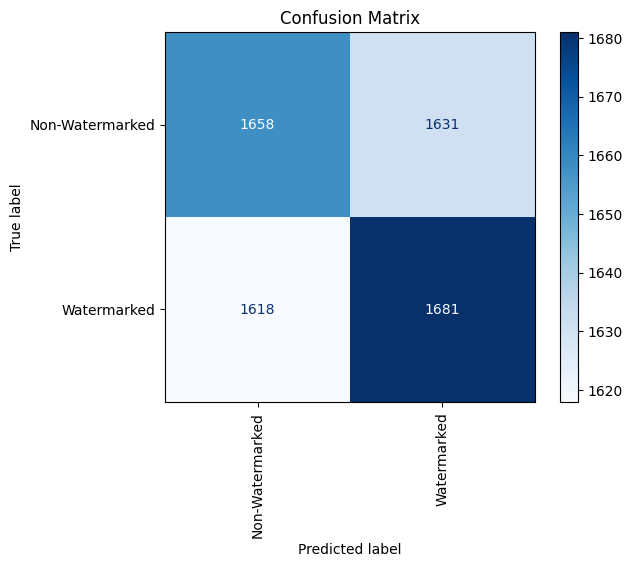

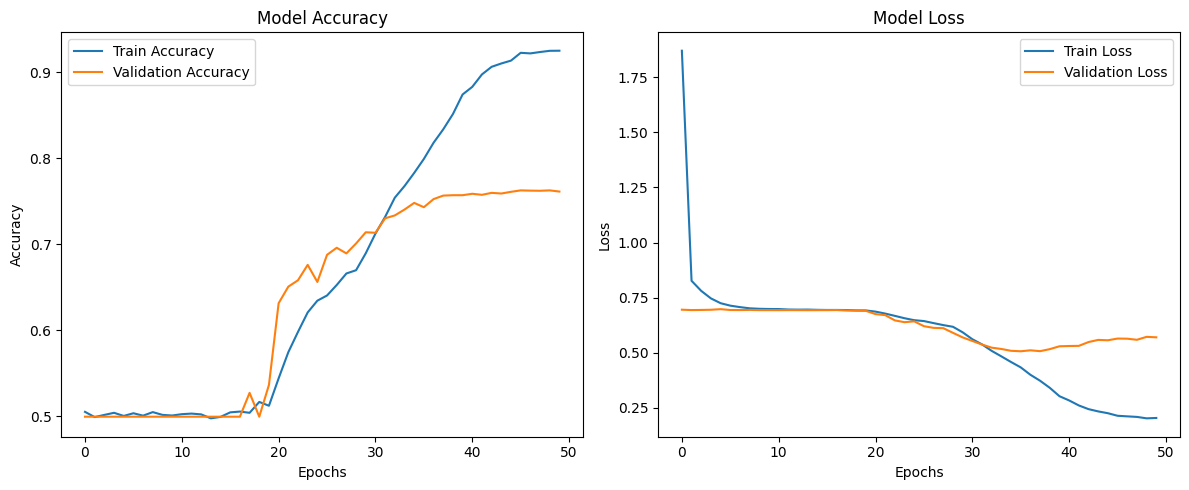

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Enable mixed precision training
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Set GPU configuration (if GPUs are enabled on Kaggle)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs available: {len(gpus)}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected. Using CPU.")

# Dataset paths for Kaggle
dataset_dir = "/kaggle/working/new"  # Change this to your actual dataset folder name
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')

# Define the CNN model architecture
def create_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='elu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='elu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation='elu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Preprocessing function
def preprocess_image(image, label):
    try:
        image = tf.cast(image, tf.float32) / 255.0  # Rescale to range [0, 1]
    except tf.errors.InvalidArgumentError as e:
        print(f"Skipping image due to error: {e}")
        return None, None
    return image, label

# Load dataset with no augmentation
batch_size = 128
img_size = (256, 256)

def load_and_preprocess_dataset(dataset_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='rgb'  # Use RGB instead of grayscale
    )
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_and_preprocess_dataset(train_dir)
valid_dataset = load_and_preprocess_dataset(valid_dir)

# Check and print class distributions
def get_class_distribution(dataset):
    # Flatten the dataset's labels and compute counts
    labels = []
    for x_batch, y_batch in dataset:
        labels.extend(y_batch.numpy())  # Convert tf.Tensor to numpy
    labels = np.array(labels)

    # Count the number of watermarked and non-watermarked instances
    watermarked_count = np.sum(labels == 1)
    non_watermarked_count = np.sum(labels == 0)

    print(f"Number of watermarked samples: {watermarked_count}")
    print(f"Number of non-watermarked samples: {non_watermarked_count}")
    print(f"Total samples: {len(labels)}")

# Print class distribution for training dataset
print("Training dataset class distribution:")
get_class_distribution(train_dataset)

# Create the CNN model
model = create_cnn_model(input_shape=(256, 256, 3))  # Use 3 channels for RGB images

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(valid_dataset, verbose=2)
print(f"Validation Accuracy: {test_accuracy:.2f}")

# Predict and calculate metrics
y_true = np.concatenate([y for x, y in valid_dataset if x is not None])  # Filter out None images
y_pred_probs = model.predict(valid_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Watermarked', 'Watermarked']))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Watermarked', 'Watermarked'])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()